# XAFS scan

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Example multi-segment XAFS scan.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
try:
    %load_ext dotenv
    %dotenv env.txt
except Exception:
    print(
        "Did not load file with environment variables."
        "  No problem.  Continuing ..."
    )

Did not load file with environment variables.  No problem.  Continuing ...


In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Tue-21:32:02 - ############################################################ startup
I Tue-21:32:02 - logging started
I Tue-21:32:02 - logging level = 10
I Tue-21:32:02 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Tue-21:32:02 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Tue-21:32:03 - #### Bluesky Framework ####
I Tue-21:32:03 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Tue-21:32:03 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Tue-21:32:03 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Tue-21:32:04 - using databroker catalog 'training'
I Tue-21:32:04 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Tue-21:32:04 - #### Devices ####
I Tue-21:32:04 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Tue-21:32:04 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Tue-21:32:06 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Tue-21:32:06 - /h

In [4]:
from ophyd import EpicsSignalRO

import math
import numpy as np
import pint
import scipy.constants

In [6]:
ureg = pint.UnitRegistry()
hbar = ureg.Quantity(scipy.constants.hbar, "J Hz^-1")
electron_mass = ureg.Quantity(scipy.constants.m_e, "kg")
TWO_M_OVER_HBAR_SQR = 2 * electron_mass / (hbar**2)


def energy_to_k(E, E0):
    """
    k = sqrt( (2m(E-E0)) / hbar^2) = sqrt( const * (E-E0))
    """
    energy_difference = ureg.Quantity(E - E0, "keV")
    kSqr = (TWO_M_OVER_HBAR_SQR * energy_difference).to("1/angstrom^2")
    return math.sqrt(kSqr.magnitude)


def k_to_energy(k, E0):
    k_with_units = ureg.Quantity(k, "1/angstrom")
    edge_keV = ureg.Quantity(E0, "keV")
    energy_difference = (k_with_units**2 / TWO_M_OVER_HBAR_SQR).to("keV")
    return (energy_difference + edge_keV).magnitude


In [7]:
DEFAULT_XAFS_SCAN_SEGMENTS = (
    # X could be keV, eV, k, or kwt (k-weighted count time)
    # X, start, end, step, t
    ("keV", -.2, -.015, .02, 3),
    ("eV", -15, 10, 2.5, 1),
    ("k", .5, 2, .2, 0.5),
    ("kwt", 2, 10, .5, 1),
)

def get_energies_and_times(edge_keV, segments):
    accepted = "keV eV k kwt"

    results = []

    for i, seg in enumerate(segments):
        # error checking
        if seg[0].lower() not in accepted.lower().split():
            raise ValueError(
                f"Cannot scan in {seg[0]} now (segment {i+1})."
                f"  Only one of these: {accepted.split()}."
            )
        if len(seg) != 5:
            raise ValueError(
                "Each segment must have 5 arguments:"
                " X, start, end, step, time"
                f"  Received: {seg} in segment {i+1}"
            )

        axis_type = seg[0]
        preset_time = seg[4]
        position_array = np.arange(*seg[1:4])

        if axis_type.lower() == "kev":
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "ev":
            position_array /= 1000.0  # convert to keV
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "k":
            position_array = np.array([
                k_to_energy(k, edge_keV)
                for k in position_array
            ]) - edge_keV
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "kwt":
            # k-axis, k-weighted time
            k_array = position_array.tolist()
            position_array = np.array([
                k_to_energy(k, edge_keV)
                for k in position_array
            ]) - edge_keV
            # count time varies with k across this segment
            # time = preset*(1 + factor * k**exponent)
            factor = 2
            exponent = .5
            time_array = np.array([
                preset_time * (1 + factor * k**exponent)
                for k in k_array
            ])

        results += [
            (edge_keV + v, t)
            for v, t in zip(position_array, time_array)
        ]

    return sorted(results)


In [8]:
def prep_absorption_calc(absorption):
    """
    Use a userCalc to compute ln(I00/I0) for real-time plots in collection.

    PARAMETERS

    absorption
        obj: instance of apstools.synApps.SwaitRecord()
    """
    absorption.reset()
    s = scaler1.channels
    yield from bps.mv(
        absorption.channels.A.input_pv, s.chan02.s.pvname,  # I0
        absorption.channels.B.input_pv, s.chan06.s.pvname,  # I00
        absorption.calculation, "ln(B/A)",  # ln(I00/I0)
        absorption.scanning_rate, "I/O Intr",
    )

In [9]:
def xafs_scan(edge_keV, segments=None, detectors=None):
    """
    Scan an edge: (keV

    EXAMPLE::

        RE(xafs_scan(7.1125))  # scan iron K edge
    """
    if detectors is None:
        detectors = [scaler1]
    if segments is None:
        segments = DEFAULT_XAFS_SCAN_SEGMENTS
    if len(segments) == 0:
        return  # nothing to do

    # use userCalc2 to calculate absorption
    absorption = calcs.calc2
    yield from prep_absorption_calc(absorption)

    # override: just get the one signal
    absorption = EpicsSignalRO(
        calcs.calc2.calculated_value.pvname,
        name="absorption",
        kind="hinted"
    )
    detectors.append(absorption)

    scaler1.select_channels(("I0", "I00"))

    elist, tlist = [], []
    for pair in get_energies_and_times(edge_keV, segments):
        elist.append(pair[0])
        tlist.append(pair[-1])

    comment = (
        f"xafs_scan of {len(segments)} (combined) near {edge_keV} keV"
        f": {len(elist)} points total"
    )
    logger.info(comment)
    yield from bp.list_scan(
        detectors,
        dcm.energy, elist,
        scaler1.preset_time, tlist,
        md=dict(
            purpose=comment,
            plan_name="xafs_scan"
        )
    )

I Tue-21:37:17 - xafs_scan of 4 (combined) near 7.1125 keV: 44 points total




Transient Scan ID: 528     Time: 2021-10-19 21:37:17
Persistent Unique Scan ID: '004ef3db-ec9a-4f6d-9124-9ab589bf8559'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time | dcm_energy |         I0 |        I00 | absorption |
+-----------+------------+------------+------------+------------+------------+
|         1 | 21:37:34.7 |     6.9122 |         16 |         14 |   -0.13353 |
|         2 | 21:37:38.7 |     6.9325 |         16 |         17 |    0.06062 |
|         3 | 21:37:42.6 |     6.9528 |         16 |         17 |    0.06062 |
|         4 | 21:37:46.5 |     6.9734 |         14 |         16 |    0.13353 |
|         5 | 21:37:50.4 |     6.9940 |         17 |         14 |   -0.19416 |
|         6 | 21:37:54.5 |     7.0106 |         16 |         15 |   -0.06454 |
|         7 | 21:37:58.6 |     7.0315 |         15 |         15 |    0.00000 |
|         8 | 21:38:02.7 |     7.0525 |     

/home/prjemian/.local/lib/python3.8/site-packages/bluesky/callbacks/fitting.py:284: RuntimeWarning: divide by zero encountered in double_scalars
  m = dy / dx


('004ef3db-ec9a-4f6d-9124-9ab589bf8559',)

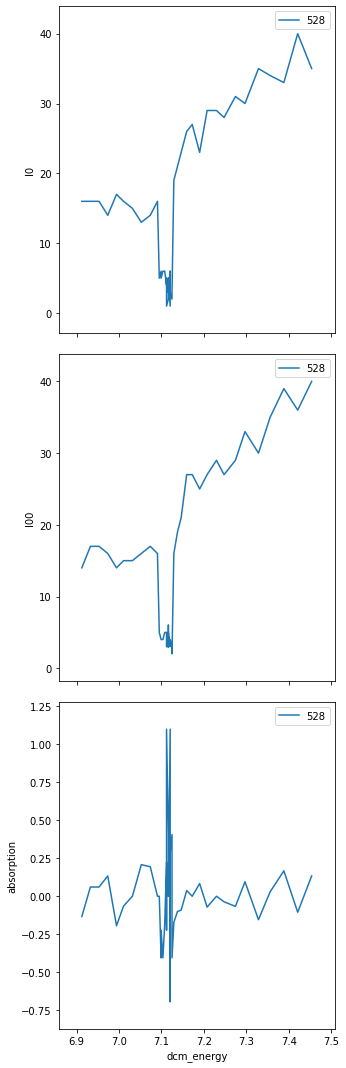

In [10]:
RE(xafs_scan(7.1125))